In [1]:
# Create an ML algorithm that can accurately predict the time a car will spend on the test bench 
# based on the vehicle configuration

# Agenda
# 1. If for any column(s), the variance is equal to zero, then you need to remove those variable(s)
# 2. Check for null and unique values for test and train sets
# 3. Apply label encoder for categorical variables
# 4. Perform dimensaionlity reduction with PCA
# 5. Predict the test_df values using xgboost

In [2]:
# Importing the required libraries
# Loading the train/test data
# The lowercase alphabets are categorical variables
import numpy as np
import pandas as pd

train = pd.read_csv('train.csv')
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print('Size of training set')
print(train.shape)

Size of training set
(4209, 378)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [5]:
# Separating y column as this is for prediction output
y_train = train['y'].values
y_train

array([130.81,  88.53,  76.26, ..., 109.22,  87.48, 110.85])

In [6]:
# A lot of columns that have an X 
# Let's check for the same 
# 376 features with X
colums_x = [c for c in train.columns if 'X' in c]

# info about colums_x
print(len(colums_x))
print(train[colums_x].dtypes.value_counts())

376
int64     368
object      8
dtype: int64


In [7]:
# Looking at the test dataset for simiilar features
test = pd.read_csv('test.csv')
test.head()


,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [8]:
print('Size of training set')
test.shape

Size of training set


(4209, 377)

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(369), object(8)
memory usage: 12.1+ MB


In [10]:
# Creating the final dataset
# Removing unwanted columns (ID); y has been removed earlier
final_column = list(set(train.columns) - set(['ID', 'y']))

x_train = train[final_column]
# x_train
x_test = test[final_column]
# x_test

In [11]:
# Searching for null values
# Creating a function for the same
def detect(df):
    if df.isnull().any().any():
        print("Yes")
    else:
        print("No")

detect(x_train)
detect(x_test)

# Observation : There are no missing values.

No
No


In [12]:
## EDA
# Integer Columns Analysis
unique_value_dict = {}
for col in x_train.columns:
    if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(x_train[col].unique()).tolist())
        t_list = unique_value_dict.get(unique_value, [])
        t_list.append(col)
        unique_value_dict[unique_value] = t_list[:]
for unique_val, columns in unique_value_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("-----------------------------------------------------------")

Columns containing the unique values :  [0, 1]
['X247', 'X51', 'X274', 'X270', 'X219', 'X148', 'X116', 'X236', 'X186', 'X23', 'X33', 'X35', 'X382', 'X47', 'X106', 'X134', 'X18', 'X70', 'X171', 'X359', 'X80', 'X374', 'X29', 'X288', 'X253', 'X131', 'X273', 'X178', 'X189', 'X168', 'X91', 'X32', 'X252', 'X28', 'X105', 'X136', 'X282', 'X311', 'X125', 'X153', 'X64', 'X95', 'X205', 'X320', 'X292', 'X266', 'X38', 'X368', 'X90', 'X159', 'X351', 'X169', 'X225', 'X96', 'X98', 'X27', 'X109', 'X142', 'X94', 'X151', 'X334', 'X37', 'X342', 'X209', 'X162', 'X196', 'X369', 'X13', 'X129', 'X57', 'X185', 'X104', 'X256', 'X267', 'X315', 'X81', 'X319', 'X158', 'X302', 'X316', 'X226', 'X190', 'X241', 'X211', 'X231', 'X69', 'X141', 'X77', 'X140', 'X56', 'X363', 'X146', 'X321', 'X357', 'X276', 'X76', 'X114', 'X175', 'X326', 'X337', 'X191', 'X379', 'X88', 'X305', 'X103', 'X350', 'X294', 'X31', 'X370', 'X366', 'X281', 'X317', 'X345', 'X145', 'X39', 'X237', 'X318', 'X135', 'X338', 'X258', 'X71', 'X376', 'X97', '

In [13]:
# Removal of columns with a variance of 0
# means columns that have only one unique value 0. 

for column in final_column:
    check = len(np.unique(x_train[column]))
    if check == 1:
        x_train.drop(column, axis = 1, inplace=True) 
        x_test.drop(column, axis = 1, inplace=True)

x_train.head()

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,X247,X51,X274,X270,X219,X148,X116,X236,X4,X186,...,X340,X45,X229,X55,X12,X254,X283,X1,X306,X160
0,0,0,0,0,0,0,1,0,d,0,...,0,0,0,0,0,0,0,v,1,0
1,0,1,0,0,0,0,0,0,d,0,...,0,0,1,0,0,0,0,t,0,0
2,0,1,1,0,1,1,0,0,d,0,...,0,0,0,0,0,0,0,w,0,0
3,0,0,0,0,0,1,0,0,d,0,...,0,0,1,0,0,0,0,t,0,0
4,0,1,0,0,0,1,0,0,d,0,...,0,0,1,0,0,0,0,v,0,0


In [14]:
## Label encoding the Categorical columns
from sklearn import preprocessing
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[f].values)) 
        x_train[f] = lbl.transform(list(x_train[f].values))
        #x_test[f] = lbl.transform(list(x_test[f].values))   ## as values in test dataset differs from train set

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


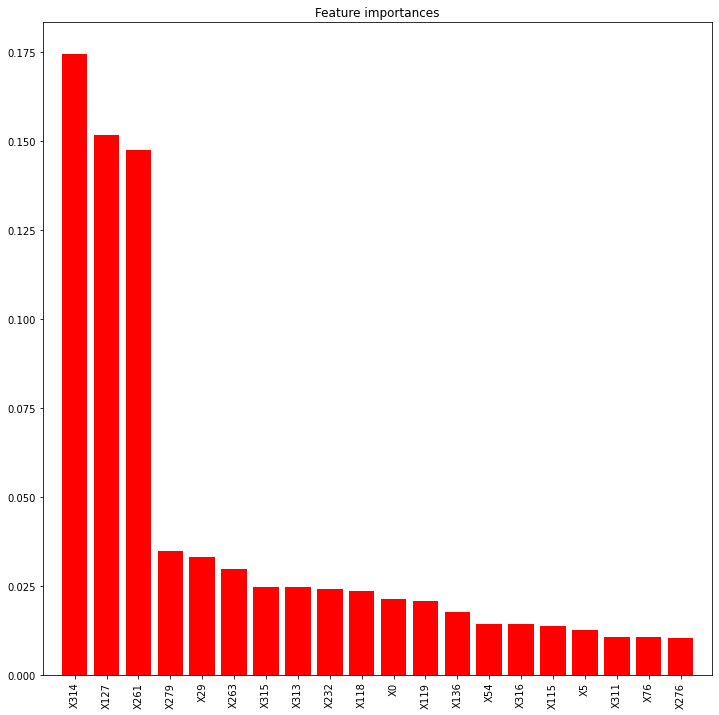

In [15]:
## Let us build a Random Forest model and check the important variables.

from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200, 
                                       max_depth=10, min_samples_leaf=4, 
                                       max_features=0.2, n_jobs=-1, 
                                       random_state=0)
model.fit(x_train, y_train)
feat_names = x_train.columns.values

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [16]:
# Performing dimensionality reduction with principal components analysis
from sklearn.decomposition import PCA
n_comp = 12
pca = PCA(n_components = n_comp, random_state = 42)
pca_result_train = pca.fit_transform(x_train)
##pca_result_test = pca.transform(x_test)


In [17]:
# ML Modeling with XGboost
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Splitting the data by 80/20
x_train, x_valid, y_train, y_valid = train_test_split(pca_result_train, 
                                                      y_train, 
                                                      test_size = 0.2, 
                                                      random_state = 42)

In [18]:
# Building the final feature set
f_train = xgb.DMatrix(x_train, label = y_train)
f_valid = xgb.DMatrix(x_valid, label = y_valid)

In [19]:
# Setting the parameters for XGB
params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02  ## eta means learning rate
params['max_depth'] = 4

In [20]:
# Predicting the score
# Creating a function for the same

def scorer(m, w):
    labels = w.get_label()
    return 'r2', r2_score(labels, m)

final_set = [(f_train, 'train'), (f_valid, 'valid')]

P = xgb.train(params, f_train, 1000, final_set, early_stopping_rounds=50, feval=scorer, maximize=True, verbose_eval=10)



[15:15:22] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:98.99704	valid-rmse:98.88675	train-r2:-59.49743	valid-r2:-61.82424
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.14532	valid-rmse:81.05431	train-r2:-39.64615	valid-r2:-41.20883
[20]	train-rmse:66.60017	valid-rmse:66.52771	train-r2:-26.38061	valid-r2:-27.43520
[30]	train-rmse:54.76085	valid-rmse:54.72092	train-r2:-17.51112	valid-r2:-18.23791
[40]	train-rmse:45.14307	valid-rmse:45.11907	train-r2:-11.57983	valid-r2:-12.07891
[50]	train-rmse:37.35343	valid-rmse:37.35661	train-r2:-7.61298	valid-r2:-7.96573
[60]	train-rmse:31.07077	valid-rmse:31.08922	train-r2:-4.95932	valid-r2:-5.20970
[70]	train-rmse:26.02783	valid-rmse:26.04540	train-r2:-3.18185	valid-r2:-3.35826
[80]	train-rmse:22.00439	valid-rmse:22.02672	train-r2:-1.98890	valid-r2:-2.

In [21]:
# Predicting on test set
p_test = P.predict(f_valid)
p_test

array([ 92.60499 ,  96.806854, 102.80264 ,  79.457   , 111.14049 ,
       101.756035,  92.88736 , 102.632   , 102.81461 , 114.01289 ,
        77.04445 ,  96.07492 ,  96.87875 , 103.35972 ,  96.36682 ,
        95.68255 , 109.60038 ,  97.138   ,  95.19734 , 115.63238 ,
       112.34259 ,  98.16956 ,  96.117035, 101.5805  ,  93.74107 ,
       111.3088  ,  96.555145,  78.199066,  93.47996 ,  94.52608 ,
        94.96783 , 102.384865,  97.06934 , 109.00841 ,  98.18227 ,
       113.868645, 113.02013 ,  99.33244 ,  92.98425 ,  99.22035 ,
       112.89446 , 101.96907 , 118.01389 , 108.41425 ,  96.2537  ,
       102.12306 ,  91.533966, 103.979225, 109.84129 , 104.8943  ,
        94.53346 ,  98.731186, 103.45173 , 107.13904 , 100.23186 ,
       101.31478 ,  98.88241 , 111.5741  ,  95.82149 ,  97.51418 ,
       109.04537 ,  76.7217  ,  95.34523 ,  95.91618 ,  77.54216 ,
        98.24471 ,  95.23625 ,  99.64998 , 104.8943  ,  99.94928 ,
        94.26675 ,  94.351074,  99.41977 , 105.952446,  96.031

In [22]:
Predicted_Data = pd.DataFrame()
Predicted_Data['y'] = p_test
Predicted_Data.head()

,y
0,92.604988
1,96.806854
2,102.802643
3,79.457001
4,111.140488
